##Instalación de módulos necesarios

In [1]:
!pip install pycaret

##Lectura de librerias

In [109]:
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score as R2
import pathlib
import numpy as np
from pycaret.regression import *
from scipy.stats import poisson
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import datetime
from scipy import stats
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
from datetime import datetime, date, timedelta
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
import statsmodels.formula.api as smf
import statsmodels.api as sm
from pandas.core import apply
from sklearn.linear_model import LinearRegression

##Lectura de datos

In [3]:
datos=pd.read_excel('/content/registros_autos_entrenamiento.xlsx')
festivos = pd.read_excel('/content/festivos (2).xlsx')
#navidad = pd.read_excel('/content/christmas.xlsx')
#año_nuevo=pd.read_excel('/content/año_nuevo.xlsx')

##Agregar variables

In [4]:
anio=pd.DataFrame({'Fecha': pd.to_datetime(datos['Fecha'].values)})
datos['Year']=anio['Fecha'].dt.year
datos['Mes']=anio['Fecha'].dt.month
datos['Dia']=anio['Fecha'].dt.day
datos['DiaNom'] = anio['Fecha'].dt.day_name()
datos['quincena'] = np.where(datos.loc[:,'Fecha'].dt.day.isin([15,30,31]),1,0)
datos['festivos'] = np.where(datos.loc[:,'Fecha'].isin(festivos['holidays_fecha']),1,0)
#datos['navidad'] = np.where(datos.loc[:,'Fecha'].isin(navidad['christmas_fecha']),1,0)
#datos['año_nuevo'] = np.where(datos.loc[:,'Fecha'].isin(año_nuevo['primer_dia_año']),1,0)
datos

,Fecha,Unidades,Year,Mes,Dia,DiaNom,quincena,festivos
0,2012-01-01,0,2012,1,1,Sunday,0,0
1,2012-01-02,188,2012,1,2,Monday,0,0
2,2012-01-03,482,2012,1,3,Tuesday,0,0
3,2012-01-04,927,2012,1,4,Wednesday,0,0
4,2012-01-05,1159,2012,1,5,Thursday,0,0
...,...,...,...,...,...,...,...,...
2187,2017-12-27,2102,2017,12,27,Wednesday,0,0
2188,2017-12-28,3449,2017,12,28,Thursday,0,0
2189,2017-12-29,1084,2017,12,29,Friday,0,0
2190,2017-12-30,18,2017,12,30,Saturday,1,0


##Revisión y tratamiento de outliers

<AxesSubplot: >

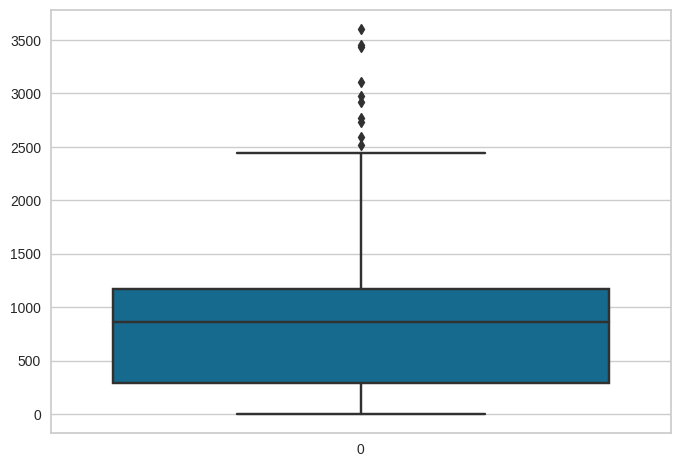

In [5]:
sns.boxplot(datos['Unidades'])

In [6]:
z = np.abs(stats.zscore(datos["Unidades"]))
datos["Z_CT"]=z
datos[datos["Z_CT"]>1]

,Fecha,Unidades,Year,Mes,Dia,DiaNom,quincena,festivos,Z_CT
0,2012-01-01,0,2012,1,1,Sunday,0,0,1.419438
1,2012-01-02,188,2012,1,2,Monday,0,0,1.078264
7,2012-01-08,0,2012,1,8,Sunday,0,0,1.419438
8,2012-01-09,0,2012,1,9,Monday,0,1,1.419438
14,2012-01-15,1,2012,1,15,Sunday,1,0,1.417623
...,...,...,...,...,...,...,...,...,...
2185,2017-12-25,0,2017,12,25,Monday,0,1,1.419438
2187,2017-12-27,2102,2017,12,27,Wednesday,0,0,2.395174
2188,2017-12-28,3449,2017,12,28,Thursday,0,0,4.839647
2190,2017-12-30,18,2017,12,30,Saturday,1,0,1.386772


In [7]:
outliers=(datos[datos["Z_CT"]>=1.1])
outliers.head(50)

,Fecha,Unidades,Year,Mes,Dia,DiaNom,quincena,festivos,Z_CT
0,2012-01-01,0,2012,1,1,Sunday,0,0,1.419438
7,2012-01-08,0,2012,1,8,Sunday,0,0,1.419438
8,2012-01-09,0,2012,1,9,Monday,0,1,1.419438
14,2012-01-15,1,2012,1,15,Sunday,1,0,1.417623
21,2012-01-22,0,2012,1,22,Sunday,0,0,1.419438
28,2012-01-29,2,2012,1,29,Sunday,0,0,1.415808
35,2012-02-05,0,2012,2,5,Sunday,0,0,1.419438
42,2012-02-12,1,2012,2,12,Sunday,0,0,1.417623
49,2012-02-19,0,2012,2,19,Sunday,0,0,1.419438
56,2012-02-26,0,2012,2,26,Sunday,0,0,1.419438


In [8]:
df=datos[datos["Z_CT"]<=1]

In [9]:
df

,Fecha,Unidades,Year,Mes,Dia,DiaNom,quincena,festivos,Z_CT
2,2012-01-03,482,2012,1,3,Tuesday,0,0,0.544727
3,2012-01-04,927,2012,1,4,Wednesday,0,0,0.262839
4,2012-01-05,1159,2012,1,5,Thursday,0,0,0.683862
5,2012-01-06,996,2012,1,6,Friday,0,0,0.388057
6,2012-01-07,243,2012,1,7,Saturday,0,0,0.978453
...,...,...,...,...,...,...,...,...,...
2176,2017-12-16,262,2017,12,16,Saturday,0,0,0.943972
2178,2017-12-18,959,2017,12,18,Monday,0,0,0.320911
2183,2017-12-23,496,2017,12,23,Saturday,0,0,0.519320
2186,2017-12-26,1251,2017,12,26,Tuesday,0,0,0.850819


##Descripción de los datos

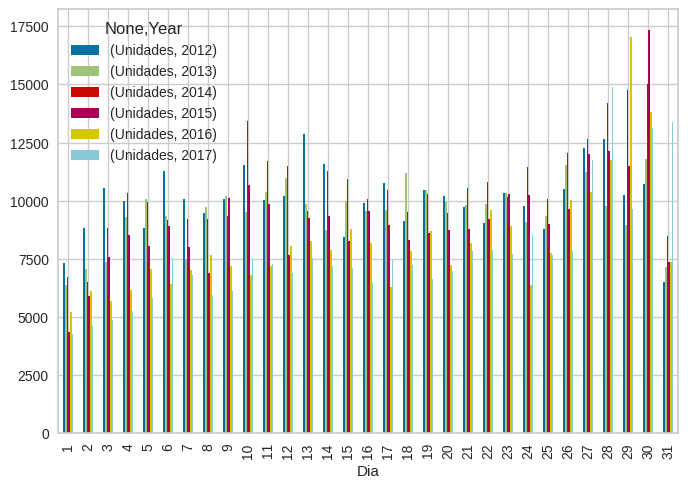

In [10]:
diaxyear = datos.groupby(['Dia','Year'])[['Unidades']].sum().unstack()
diaxyear.plot.bar()
plt.show()

Unidades                                   
Year     2012   2013   2014   2015   2016   2017
Mes                                             
1       20390  19541  20220  21366  16829  17307
2       24840  21865  23870  23010  20380  18036
3       29217  21707  24184  24810  19849  21200
4       23945  26633  26222  21983  20415  17184
5       27066  24835  27013  22649  19580  20025
6       24691  22719  23152  22623  20742  19926
7       25638  26205  27767  26741  17652  18711
8       25988  23856  27536  23329  22553  21029
9       25557  24850  29647  25015  21497  19436
10      26412  26701  31533  22569  19289  19815
11      24473  25079  25816  21102  22505  21274
12      33703  31812  40518  29719  33602  25554

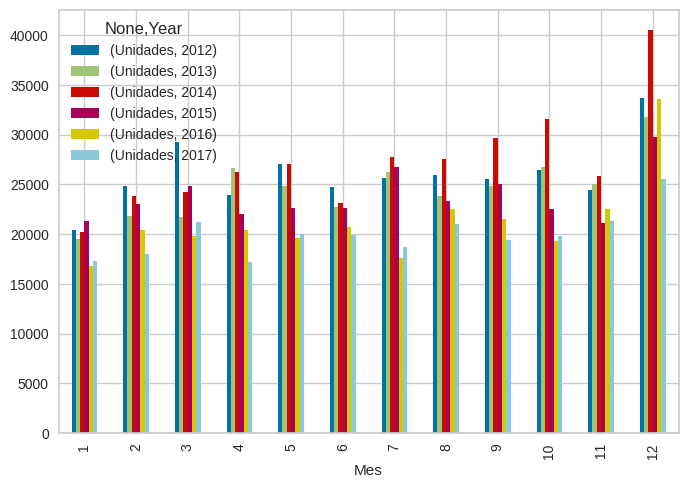

In [11]:
mesxyear = datos.groupby(['Mes','Year'])[['Unidades']].sum().unstack()
mesxyear.plot.bar()
mesxyear

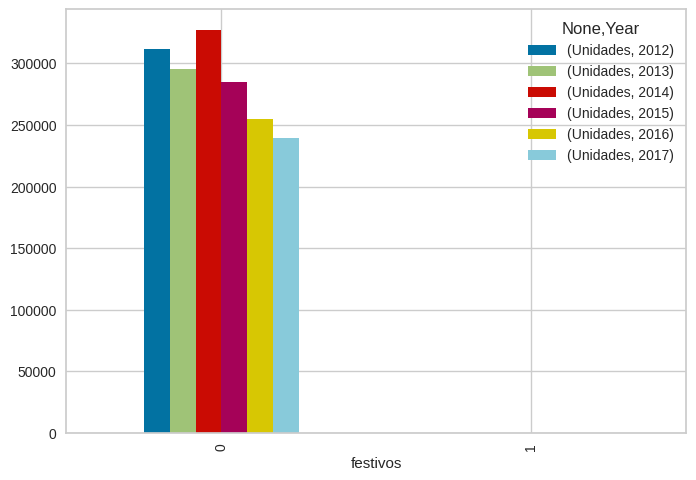

In [12]:
festivoxyear = datos.groupby(['festivos','Year'])[['Unidades']].sum().unstack()
festivoxyear.plot.bar()
plt.show()

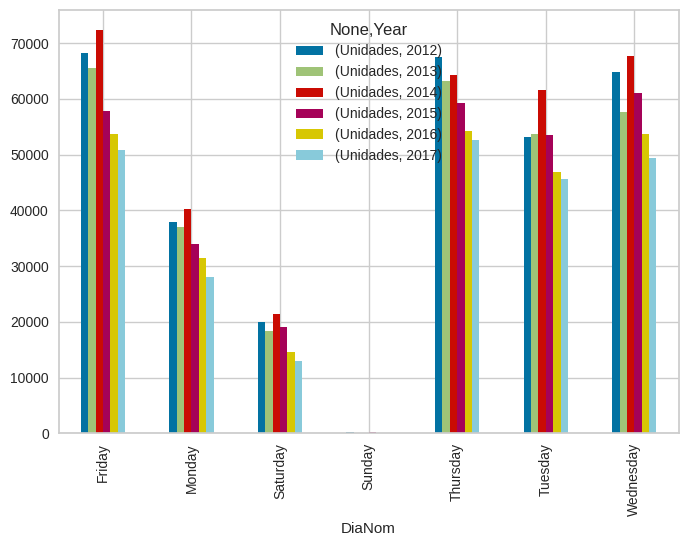

In [13]:
dianomxyear = datos.groupby(['DiaNom','Year'])[['Unidades']].sum().unstack()
dianomxyear.plot.bar()
plt.show()

In [14]:
X_train = df[df['Fecha'] < '2017-01-01']
X_train = X_train[['Year',	'Mes','festivos','Dia','quincena','DiaNom','Unidades']]
X_train

,Year,Mes,festivos,Dia,quincena,DiaNom,Unidades
2,2012,1,0,3,0,Tuesday,482
3,2012,1,0,4,0,Wednesday,927
4,2012,1,0,5,0,Thursday,1159
5,2012,1,0,6,0,Friday,996
6,2012,1,0,7,0,Saturday,243
...,...,...,...,...,...,...,...
1812,2016,12,0,17,0,Saturday,378
1814,2016,12,0,19,0,Monday,1240
1819,2016,12,0,24,0,Saturday,334
1821,2016,12,0,26,0,Monday,1234


##División conjunto de entrenamiento y de validación

In [15]:
X_test = df[df['Fecha'] >= '2017-01-01']
X_test = X_test[['Year',	'Mes',	'Dia','quincena','festivos', 'DiaNom', 'Unidades']]
X_test.reset_index(inplace = True)
X_test =  X_test.drop(['index'], axis = 1)
X_test

,Year,Mes,Dia,quincena,festivos,DiaNom,Unidades
0,2017,1,4,0,0,Wednesday,232
1,2017,1,5,0,0,Thursday,455
2,2017,1,6,0,0,Friday,776
3,2017,1,10,0,0,Tuesday,609
4,2017,1,11,0,0,Wednesday,727
...,...,...,...,...,...,...,...
234,2017,12,16,0,0,Saturday,262
235,2017,12,18,0,0,Monday,959
236,2017,12,23,0,0,Saturday,496
237,2017,12,26,0,0,Tuesday,1251


In [16]:
X_train = pd.get_dummies(X_train)
X_train

,Year,Mes,festivos,Dia,quincena,Unidades,DiaNom_Friday,DiaNom_Monday,DiaNom_Saturday,DiaNom_Thursday,DiaNom_Tuesday,DiaNom_Wednesday
2,2012,1,0,3,0,482,0,0,0,0,1,0
3,2012,1,0,4,0,927,0,0,0,0,0,1
4,2012,1,0,5,0,1159,0,0,0,1,0,0
5,2012,1,0,6,0,996,1,0,0,0,0,0
6,2012,1,0,7,0,243,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1812,2016,12,0,17,0,378,0,0,1,0,0,0
1814,2016,12,0,19,0,1240,0,1,0,0,0,0
1819,2016,12,0,24,0,334,0,0,1,0,0,0
1821,2016,12,0,26,0,1234,0,1,0,0,0,0


In [17]:
X_test = pd.get_dummies(X_test)
X_test

,Year,Mes,Dia,quincena,festivos,Unidades,DiaNom_Friday,DiaNom_Monday,DiaNom_Saturday,DiaNom_Thursday,DiaNom_Tuesday,DiaNom_Wednesday
0,2017,1,4,0,0,232,0,0,0,0,0,1
1,2017,1,5,0,0,455,0,0,0,1,0,0
2,2017,1,6,0,0,776,1,0,0,0,0,0
3,2017,1,10,0,0,609,0,0,0,0,1,0
4,2017,1,11,0,0,727,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
234,2017,12,16,0,0,262,0,0,1,0,0,0
235,2017,12,18,0,0,959,0,1,0,0,0,0
236,2017,12,23,0,0,496,0,0,1,0,0,0
237,2017,12,26,0,0,1251,0,0,0,0,1,0


In [18]:
numerico = list(X_train.columns.values)
numerico.remove('Unidades')
numerico

['Year',
 'Mes',
 'festivos',
 'Dia',
 'quincena',
 'DiaNom_Friday',
 'DiaNom_Monday',
 'DiaNom_Saturday',
 'DiaNom_Thursday',
 'DiaNom_Tuesday',
 'DiaNom_Wednesday']

##Comparación de modelos

In [19]:
comparar = setup(data = X_train, target = 'Unidades', numeric_features = numerico , normalize = True, session_id = 1234)

,Description,Value
0,Session id,1234
1,Target,Unidades
2,Target type,Regression
3,Original data shape,"(1193, 12)"
4,Transformed data shape,"(1193, 12)"
5,Transformed train set shape,"(835, 12)"
6,Transformed test set shape,"(358, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


In [20]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,94.2873,16791.7012,128.0772,0.8275,0.1654,0.1246,0.0960
lightgbm,Light Gradient Boosting Machine,97.9356,18820.1065,136.0456,0.8062,0.1790,0.1326,0.4940
xgboost,Extreme Gradient Boosting,102.9166,20179.7463,140.9978,0.7910,0.1845,0.1357,0.0790
rf,Random Forest Regressor,101.6488,20551.8874,141.8534,0.7888,0.1819,0.1340,0.6970
et,Extra Trees Regressor,102.0180,21342.4214,144.1398,0.7815,0.1839,0.1352,0.3070
knn,K Neighbors Regressor,112.5203,23974.6943,152.9334,0.7533,0.1997,0.1510,0.0600
lr,Linear Regression,121.1701,25669.8199,158.9605,0.7337,0.2115,0.1626,1.1890
br,Bayesian Ridge,121.7762,25785.2735,159.2541,0.7327,0.2119,0.1639,0.0710
lar,Least Angle Regression,121.6679,25786.1532,159.2532,0.7326,0.2118,0.1635,0.0480
llar,Lasso Least Angle Regression,121.8415,25798.9394,159.2936,0.7326,0.2121,0.1640,0.0490


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

GradientBoostingRegressor(random_state=1234)

##Modelo Light Gradient Boosting Machine (lightgbm)

In [21]:
mlightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,104.7687,18871.2133,137.3725,0.8263,0.1714,0.1384
1,101.0742,22525.8100,150.0860,0.7781,0.2031,0.1533
2,93.2514,15447.4189,124.2876,0.8266,0.1656,0.1219
3,86.9517,11190.7410,105.7863,0.8652,0.1440,0.1084
4,84.9372,19171.2614,138.4603,0.7898,0.1850,0.1184
5,104.0231,21069.1963,145.1523,0.8049,0.1920,0.1442
6,103.2619,19615.9185,140.0568,0.8083,0.1767,0.1345
7,116.8097,29924.7426,172.9877,0.7130,0.2471,0.1766
8,85.3665,13831.3222,117.6066,0.8466,0.1460,0.1105


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [22]:
tuned_mlightgbm = tune_model(mlightgbm)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,104.9001,19800.6499,140.7148,0.8177,0.1705,0.1371
1,93.2793,19124.4313,138.2911,0.8116,0.1852,0.1388
2,83.2883,13309.7088,115.3677,0.8506,0.1547,0.1103
3,106.9683,18140.8844,134.6881,0.7815,0.1686,0.1307
4,101.5305,24397.9976,156.1986,0.7326,0.2130,0.1368
5,114.8550,25669.8887,160.2183,0.7623,0.2118,0.1605
6,106.5863,20960.1099,144.7761,0.7952,0.1842,0.1408
7,128.3481,36350.3132,190.6576,0.6514,0.2753,0.1977
8,88.8989,13612.6294,116.6732,0.8491,0.1490,0.1178


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


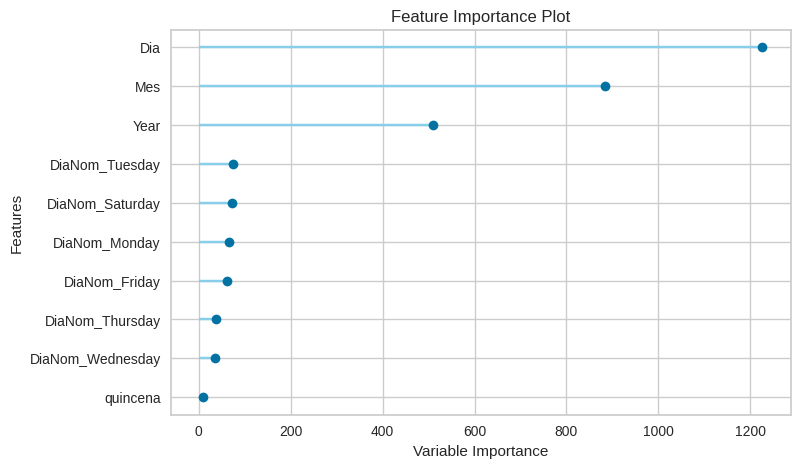

In [23]:
plot_model(tuned_mlightgbm, plot='feature')

In [24]:
X_train_predict = X_train.drop(['Unidades'], axis = 1)

In [25]:
Y_train_lightgbm = predict_model(tuned_mlightgbm, data = X_train_predict)

In [26]:
def MAE(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

In [27]:
compare_models_train = pd.DataFrame([['lightgbm',  MSE(X_train['Unidades'], Y_train_lightgbm['prediction_label']),
                                            MAE(X_train['Unidades'], Y_train_lightgbm['prediction_label']),
                                            R2(X_train['Unidades'], Y_train_lightgbm['prediction_label'])]], columns = ['Nombre', 'MSE', 'MAE', 'R2'])
compare_models_train

,Nombre,MSE,MAE,R2
0,lightgbm,10435.863764,71.056011,0.892404


In [28]:
X_test_predict = X_test.drop(['Unidades'], axis = 1)

In [29]:
Y_test_lightgbm = predict_model(tuned_mlightgbm, data = X_test_predict)

In [30]:
compare_models_test = pd.DataFrame([['lightgbm',  MSE(X_test['Unidades'], Y_test_lightgbm['prediction_label']),
                                            MAE(X_test['Unidades'], Y_test_lightgbm['prediction_label']),
                                            R2(X_test['Unidades'], Y_test_lightgbm['prediction_label'])]], columns = ['Nombre', 'MSE', 'MAE', 'R2'])
compare_models_test

,Nombre,MSE,MAE,R2
0,lightgbm,13366.510452,89.999291,0.746177


In [31]:
var1=(abs((10435.863764-13366.510452)/10435.863764))*100
var1

28.082454450102006

##Modelo Gradient Boosting Regressor (gbr)

In [32]:
mgbr = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,104.3809,18196.7002,134.8951,0.8325,0.1636,0.1346
1,91.8156,16002.6002,126.5014,0.8424,0.1682,0.1288
2,82.6507,13030.9195,114.1531,0.8538,0.1545,0.1096
3,84.0977,11174.7387,105.7106,0.8654,0.1303,0.1026
4,81.2157,13654.0371,116.8505,0.8503,0.1653,0.1090
5,96.9547,19419.8342,139.3551,0.8201,0.1830,0.1330
6,98.1205,18093.4708,134.5120,0.8232,0.1649,0.1252
7,127.2747,31281.7984,176.8666,0.7000,0.2408,0.1830
8,81.1994,11407.2245,106.8046,0.8735,0.1311,0.1032


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [33]:
tuned_mgbr = tune_model(mgbr)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,99.9891,16809.3756,129.6510,0.8452,0.1570,0.1243
1,104.3208,19695.5279,140.3408,0.8060,0.1939,0.1501
2,90.0639,13968.2318,118.1873,0.8432,0.1648,0.1190
3,85.2842,11948.4002,109.3087,0.8561,0.1443,0.1086
4,85.6766,13281.7660,115.2465,0.8544,0.1649,0.1127
5,106.7507,21299.3075,145.9428,0.8027,0.1921,0.1421
6,103.5992,20277.3098,142.3984,0.8019,0.1853,0.1342
7,126.5464,29040.5200,170.4128,0.7215,0.2427,0.1810
8,79.9242,12051.7067,109.7803,0.8664,0.1312,0.0998


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


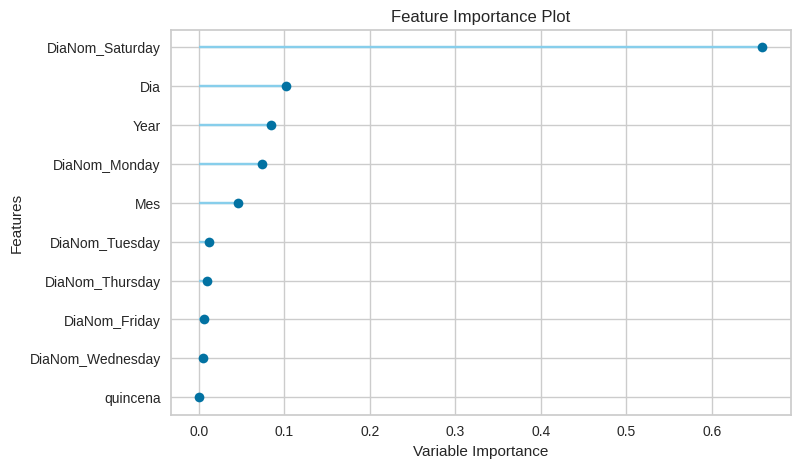

In [34]:
plot_model(tuned_mgbr, plot='feature')

In [35]:
Y_train_gbr = predict_model(tuned_mgbr, data = X_train_predict)

In [36]:
compare_gbr = {'Nombre': 'gbr',
               'MSE': MSE(X_train['Unidades'], Y_train_gbr['prediction_label']),
               'MAE': MAE(X_train['Unidades'], Y_train_gbr['prediction_label']),
               'R2': R2(X_train['Unidades'], Y_train_gbr['prediction_label'])}

compare_models_train = compare_models_train.append(compare_gbr, ignore_index=True)

In [37]:
compare_models_train.sort_values('R2', ascending=False)

,Nombre,MSE,MAE,R2
0,lightgbm,10435.863764,71.056011,0.892404
1,gbr,12633.981198,82.461490,0.869742


In [38]:
Y_test_gbr = predict_model(tuned_mgbr, data = X_test_predict)

In [39]:
compare_gbr = {'Nombre': 'gbr',
               'MSE': MSE(X_test['Unidades'], Y_test_gbr['prediction_label']),
               'MAE': MAE(X_test['Unidades'], Y_test_gbr['prediction_label']),
               'R2': R2(X_test['Unidades'], Y_test_gbr['prediction_label'])}

compare_models_test = compare_models_test.append(compare_gbr, ignore_index=True)

In [40]:
compare_models_test.sort_values('R2', ascending=False)

,Nombre,MSE,MAE,R2
0,lightgbm,13366.510452,89.999291,0.746177
1,gbr,13668.766640,91.101166,0.740438


In [41]:
var2=(abs((12633.981198	-13668.766640)/12633.981198	))*100
var2

8.190493762677201

##Modelo Random Forest Regressor (rf)

In [42]:
mrf = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,107.0344,19794.5002,140.6929,0.8178,0.1710,0.1383
1,96.4363,21275.5341,145.8614,0.7904,0.1897,0.1383
2,98.5935,17761.1276,133.2709,0.8007,0.1672,0.1215
3,84.6993,11630.5125,107.8449,0.8599,0.1355,0.1041
4,94.0810,19725.2062,140.4465,0.7838,0.1912,0.1308
5,110.0980,27049.1242,164.4662,0.7495,0.2070,0.1463
6,111.0742,22181.9395,148.9360,0.7833,0.1820,0.1370
7,129.5539,33783.9895,183.8042,0.6760,0.2557,0.1925
8,81.5265,13276.9546,115.2257,0.8528,0.1421,0.1055


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [43]:
tuned_mrf = tune_model(mrf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,108.4194,20147.4190,141.9416,0.8145,0.1727,0.1402
1,94.8916,19883.1390,141.0076,0.8041,0.1832,0.1350
2,93.1404,15517.7323,124.5702,0.8259,0.1740,0.1292
3,90.9801,13716.7552,117.1186,0.8348,0.1485,0.1129
4,103.3276,20657.5734,143.7274,0.7736,0.1890,0.1353
5,118.4728,28053.5482,167.4919,0.7402,0.2150,0.1626
6,108.4854,22200.1060,148.9970,0.7831,0.1986,0.1503
7,134.8729,38310.8331,195.7315,0.6326,0.2697,0.2004
8,84.5453,12150.1129,110.2276,0.8653,0.1380,0.1117


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


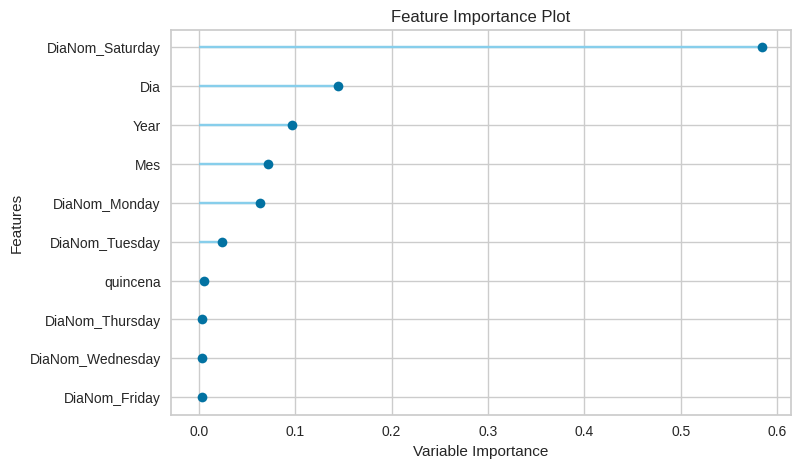

In [44]:
plot_model(tuned_mrf, plot='feature')

In [45]:
Y_train_rf = predict_model(tuned_mrf, data = X_train_predict)

In [46]:
compare_rf = {'Nombre': 'rf',
               'MSE': MSE(X_train['Unidades'], Y_train_rf['prediction_label']),
               'MAE': MAE(X_train['Unidades'], Y_train_rf['prediction_label']),
               'R2': R2(X_train['Unidades'], Y_train_rf['prediction_label'])}

compare_models_train = compare_models_train.append(compare_rf, ignore_index=True)


In [47]:
compare_models_train.sort_values(['R2'], ascending = False)

,Nombre,MSE,MAE,R2
2,rf,7394.884113,55.268826,0.923757
0,lightgbm,10435.863764,71.056011,0.892404
1,gbr,12633.981198,82.461490,0.869742


In [48]:
Y_test_rf = predict_model(tuned_mrf, data = X_test_predict)

In [49]:
compare_rf = {'Nombre': 'rf',
               'MSE': MSE(X_test['Unidades'], Y_test_rf['prediction_label']),
               'MAE': MAE(X_test['Unidades'], Y_test_rf['prediction_label']),
               'R2': R2(X_test['Unidades'], Y_test_rf['prediction_label'])}

compare_models_test = compare_models_test.append(compare_rf, ignore_index=True)

In [50]:
compare_models_test.sort_values(['R2'], ascending = False)

,Nombre,MSE,MAE,R2
0,lightgbm,13366.510452,89.999291,0.746177
1,gbr,13668.766640,91.101166,0.740438
2,rf,15408.173779,96.631632,0.707407


In [51]:
varrf=(abs((7394.884113-15408.173779)/7394.884113))*100
varrf

108.36261317351628

##Selección del Modelo Gradient Boosting Regressor

In [52]:
datadates = datos['Fecha']
datos.drop(['Fecha'], axis=1, inplace = True)

In [53]:
datos = pd.get_dummies(datos)
datos

,Unidades,Year,Mes,Dia,quincena,festivos,Z_CT,DiaNom_Friday,DiaNom_Monday,DiaNom_Saturday,DiaNom_Sunday,DiaNom_Thursday,DiaNom_Tuesday,DiaNom_Wednesday
0,0,2012,1,1,0,0,1.419438,0,0,0,1,0,0,0
1,188,2012,1,2,0,0,1.078264,0,1,0,0,0,0,0
2,482,2012,1,3,0,0,0.544727,0,0,0,0,0,1,0
3,927,2012,1,4,0,0,0.262839,0,0,0,0,0,0,1
4,1159,2012,1,5,0,0,0.683862,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187,2102,2017,12,27,0,0,2.395174,0,0,0,0,0,0,1
2188,3449,2017,12,28,0,0,4.839647,0,0,0,0,1,0,0
2189,1084,2017,12,29,0,0,0.547755,1,0,0,0,0,0,0
2190,18,2017,12,30,1,0,1.386772,0,0,1,0,0,0,0


In [54]:
setup(data = X_train, target = 'Unidades', numeric_features = numerico , normalize = True, session_id = 1234)

,Description,Value
0,Session id,1234
1,Target,Unidades
2,Target type,Regression
3,Original data shape,"(1193, 12)"
4,Transformed data shape,"(1193, 12)"
5,Transformed train set shape,"(835, 12)"
6,Transformed test set shape,"(358, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


In [55]:
mgbr = create_model('gbr')
tuned_mgbr = tune_model(mgbr)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,104.3809,18196.7002,134.8951,0.8325,0.1636,0.1346
1,91.8156,16002.6002,126.5014,0.8424,0.1682,0.1288
2,82.6507,13030.9195,114.1531,0.8538,0.1545,0.1096
3,84.0977,11174.7387,105.7106,0.8654,0.1303,0.1026
4,81.2157,13654.0371,116.8505,0.8503,0.1653,0.1090
5,96.9547,19419.8342,139.3551,0.8201,0.1830,0.1330
6,98.1205,18093.4708,134.5120,0.8232,0.1649,0.1252
7,127.2747,31281.7984,176.8666,0.7000,0.2408,0.1830
8,81.1994,11407.2245,106.8046,0.8735,0.1311,0.1032


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,99.9891,16809.3756,129.6510,0.8452,0.1570,0.1243
1,104.3208,19695.5279,140.3408,0.8060,0.1939,0.1501
2,90.0639,13968.2318,118.1873,0.8432,0.1648,0.1190
3,85.2842,11948.4002,109.3087,0.8561,0.1443,0.1086
4,85.6766,13281.7660,115.2465,0.8544,0.1649,0.1127
5,106.7507,21299.3075,145.9428,0.8027,0.1921,0.1421
6,103.5992,20277.3098,142.3984,0.8019,0.1853,0.1342
7,126.5464,29040.5200,170.4128,0.7215,0.2427,0.1810
8,79.9242,12051.7067,109.7803,0.8664,0.1312,0.0998


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


##Predicción modelo gbr entre 2012 al 2017 (Se descarta)

In [60]:
start1 = datetime.datetime.strptime("2012-01-01", "%Y-%m-%d")
end1 = datetime.datetime.strptime("2017-12-31", "%Y-%m-%d")
date_generated = pd.date_range(start1, end1)
data_generated = pd.DataFrame(date_generated, columns = ['Fecha'])
data_generated['Year'] = data_generated['Fecha'].dt.year
data_generated['Mes'] = data_generated['Fecha'].dt.month
data_generated['Dia'] = data_generated['Fecha'].dt.day
data_generated['DiaNom'] = data_generated['Fecha'].dt.day_name()
data_generated['quincena'] = np.where(data_generated.loc[:,'Fecha'].dt.day.isin([15,30,31]),1,0)
data_generated['festivos'] = np.where(data_generated.loc[:,'Fecha'].isin(festivos['holidays_fecha']),1,0)
data_generated = pd.get_dummies(data_generated)
data_generated

,Fecha,Year,Mes,Dia,quincena,festivos,DiaNom_Friday,DiaNom_Monday,DiaNom_Saturday,DiaNom_Sunday,DiaNom_Thursday,DiaNom_Tuesday,DiaNom_Wednesday
0,2012-01-01,2012,1,1,0,0,0,0,0,1,0,0,0
1,2012-01-02,2012,1,2,0,0,0,1,0,0,0,0,0
2,2012-01-03,2012,1,3,0,0,0,0,0,0,0,1,0
3,2012-01-04,2012,1,4,0,0,0,0,0,0,0,0,1
4,2012-01-05,2012,1,5,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187,2017-12-27,2017,12,27,0,0,0,0,0,0,0,0,1
2188,2017-12-28,2017,12,28,0,0,0,0,0,0,1,0,0
2189,2017-12-29,2017,12,29,0,0,1,0,0,0,0,0,0
2190,2017-12-30,2017,12,30,1,0,0,0,1,0,0,0,0


In [61]:
dates = data_generated['Fecha']

In [62]:
data_generated.drop(['Fecha'], axis = 1, inplace=True)

In [63]:
Predict_2012_2017 = predict_model(tuned_mgbr, data = data_generated)

In [64]:
Export_Predict_2012_2017 = pd.DataFrame(list(zip(dates, Predict_2012_2017['prediction_label'])), columns = ['Fecha', 'Unidades'])
Export_Predict_2012_2017

,Fecha,Unidades
0,2012-01-01,668.658018
1,2012-01-02,467.569720
2,2012-01-03,582.536173
3,2012-01-04,889.891649
4,2012-01-05,933.475168
...,...,...
2187,2017-12-27,1222.163307
2188,2017-12-28,1077.637431
2189,2017-12-29,1217.288125
2190,2017-12-30,961.152113


In [65]:
y_true = datos['Unidades']
y_pred = Export_Predict_2012_2017['Unidades']

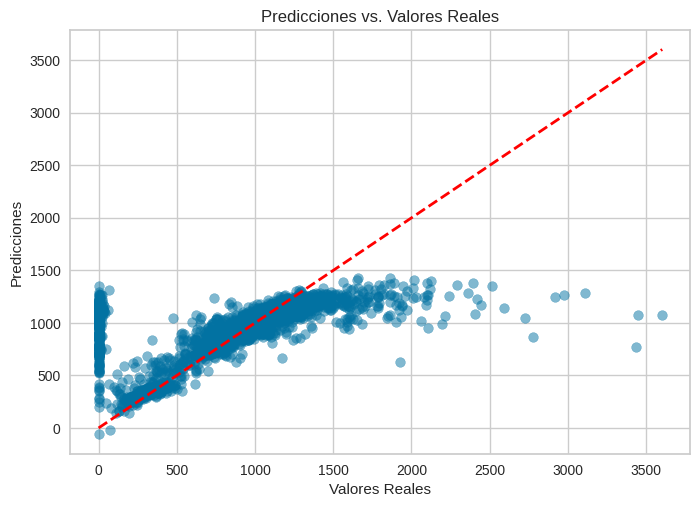

In [66]:
# Gráfica de dispersión (scatter plot)
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', linewidth=2)
plt.title('Predicciones vs. Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()

In [67]:
mae = mean_absolute_error(y_true, y_pred)
mse = MSE(y_true, y_pred)
r2 = R2(y_true, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R2: {r2}')

Mean Absolute Error (MAE): 300.7519785864491
Mean Squared Error (MSE): 241350.77095931335
R2: 0.20515209671182688


##Modelo Poisson (Seleccionado)

In [68]:
import statsmodels.formula.api as smf
from datetime import datetime, date, timedelta
import statsmodels.api as sm

In [69]:
datos1=pd.read_excel('/content/registros_autos_entrenamiento.xlsx')

In [70]:
anio=pd.DataFrame({'Fecha': pd.to_datetime(datos1['Fecha'].values)})
datos1['Year']=anio['Fecha'].dt.year
datos1['Mes']=anio['Fecha'].dt.month
datos1['Dia']=anio['Fecha'].dt.day
datos1['DiaNom'] = anio['Fecha'].dt.day_name()
datos1['festivos'] = np.where(datos1.loc[:,'Fecha'].isin(festivos['holidays_fecha']),1,0)
datos1['quincena'] = np.where(datos1.loc[:,'Fecha'].dt.day.isin([15,30,31]),1,0)
#datos1['navidad'] = np.where(datos1.loc[:,'Fecha'].isin(navidad['christmas_fecha']),1,0)
#datos1['año_nuevo'] = np.where(datos1.loc[:,'Fecha'].isin(año_nuevo['primer_dia_año']),1,0)
datos1

,Fecha,Unidades,Year,Mes,Dia,DiaNom,festivos,quincena
0,2012-01-01,0,2012,1,1,Sunday,0,0
1,2012-01-02,188,2012,1,2,Monday,0,0
2,2012-01-03,482,2012,1,3,Tuesday,0,0
3,2012-01-04,927,2012,1,4,Wednesday,0,0
4,2012-01-05,1159,2012,1,5,Thursday,0,0
...,...,...,...,...,...,...,...,...
2187,2017-12-27,2102,2017,12,27,Wednesday,0,0
2188,2017-12-28,3449,2017,12,28,Thursday,0,0
2189,2017-12-29,1084,2017,12,29,Friday,0,0
2190,2017-12-30,18,2017,12,30,Saturday,0,1


In [71]:
z = np.abs(stats.zscore(datos1["Unidades"]))
datos1["Z_CT"]=z
datos1[datos1["Z_CT"]>1.1]

,Fecha,Unidades,Year,Mes,Dia,DiaNom,festivos,quincena,Z_CT
0,2012-01-01,0,2012,1,1,Sunday,0,0,1.419438
7,2012-01-08,0,2012,1,8,Sunday,0,0,1.419438
8,2012-01-09,0,2012,1,9,Monday,1,0,1.419438
14,2012-01-15,1,2012,1,15,Sunday,0,1,1.417623
21,2012-01-22,0,2012,1,22,Sunday,0,0,1.419438
...,...,...,...,...,...,...,...,...,...
2185,2017-12-25,0,2017,12,25,Monday,1,0,1.419438
2187,2017-12-27,2102,2017,12,27,Wednesday,0,0,2.395174
2188,2017-12-28,3449,2017,12,28,Thursday,0,0,4.839647
2190,2017-12-30,18,2017,12,30,Saturday,0,1,1.386772


In [72]:
df1=datos1[datos1["Z_CT"]<=1.1]

In [73]:
train = df1[df1["Year"] <=2016]

test = df1[df1["Year"] ==2017]

In [74]:
train = pd.get_dummies(train)
train

,Fecha,Unidades,Year,Mes,Dia,festivos,quincena,Z_CT,DiaNom_Friday,DiaNom_Monday,DiaNom_Saturday,DiaNom_Thursday,DiaNom_Tuesday,DiaNom_Wednesday
1,2012-01-02,188,2012,1,2,0,0,1.078264,0,1,0,0,0,0
2,2012-01-03,482,2012,1,3,0,0,0.544727,0,0,0,0,1,0
3,2012-01-04,927,2012,1,4,0,0,0.262839,0,0,0,0,0,1
4,2012-01-05,1159,2012,1,5,0,0,0.683862,0,0,0,1,0,0
5,2012-01-06,996,2012,1,6,0,0,0.388057,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1812,2016-12-17,378,2016,12,17,0,0,0.733461,0,0,1,0,0,0
1814,2016-12-19,1240,2016,12,19,0,0,0.830857,0,1,0,0,0,0
1819,2016-12-24,334,2016,12,24,0,0,0.813310,0,0,1,0,0,0
1821,2016-12-26,1234,2016,12,26,0,0,0.819968,0,1,0,0,0,0


In [75]:
test = pd.get_dummies(test)
test

,Fecha,Unidades,Year,Mes,Dia,festivos,quincena,Z_CT,DiaNom_Friday,DiaNom_Monday,DiaNom_Saturday,DiaNom_Thursday,DiaNom_Tuesday,DiaNom_Wednesday
1830,2017-01-04,232,2017,1,4,0,0,0.998415,0,0,0,0,0,1
1831,2017-01-05,455,2017,1,5,0,0,0.593725,0,0,0,1,0,0
1832,2017-01-06,776,2017,1,6,0,0,0.011189,1,0,0,0,0,0
1833,2017-01-07,192,2017,1,7,0,0,1.071005,0,0,1,0,0,0
1836,2017-01-10,609,2017,1,10,0,0,0.314253,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178,2017-12-18,959,2017,12,18,0,0,0.320911,0,1,0,0,0,0
2179,2017-12-19,1364,2017,12,19,0,0,1.055886,0,0,0,0,1,0
2183,2017-12-23,496,2017,12,23,0,0,0.519320,0,0,1,0,0,0
2186,2017-12-26,1251,2017,12,26,0,0,0.850819,0,0,0,0,1,0


In [76]:
formula = 'Unidades~Year+Mes+Dia+festivos+quincena+DiaNom_Friday+DiaNom_Monday+DiaNom_Saturday+DiaNom_Thursday+DiaNom_Tuesday+DiaNom_Wednesday'

In [77]:
model = smf.glm(formula = formula, data=train, family=sm.families.Poisson()).fit()

In [78]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Unidades   No. Observations:                 1273
Model:                            GLM   Df Residuals:                     1263
Model Family:                 Poisson   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -26763.
Date:                Sat, 02 Dec 2023   Deviance:                       42642.
Time:                        01:13:07   Pearson chi2:                 4.28e+04
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           93.8361      1.128     83.161      0.000      91.625      96.048
Year                -0.0511      0.001    -78.158      0.000      -0.052      -0.050
Mes                  0.0103      0.000     36.980      0.000       0.010       0.011
Dia                  0.0072      0.000     63.115      0.000       0.007       0.007
festivos          1.075e-13   1.29e-15     83.046      0.000    1.05e-13     1.1e-13
quincena             0.0352      0.004      9.122      0.000       0.028       0.043
DiaNom_Friday       15.9142      0.188     84.597      0.000      15.545      16.283
DiaNom_Monday       15.5853      0.188     82.883      0.000      15.217      15.954
DiaNom_Saturday     14.8014      0.188     78.708      0.000      14.433      15.170
DiaNom_Thursday     15.9053      0.188     84.554      0.000      15.537      16.274
DiaNom_Tuesday      15.7580      0.188     83.799      0.000      15.389      16.127
DiaNom_Wednesday    15.8719      0.188     84.391      0.000      15.503      16.241
====================================================================================
"""

In [79]:
predict_tr = model.predict(train)
predict_tes = model.predict(test)

In [80]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1273 entries, 1 to 1825
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Fecha             1273 non-null   datetime64[ns]
 1   Unidades          1273 non-null   int64         
 2   Year              1273 non-null   int64         
 3   Mes               1273 non-null   int64         
 4   Dia               1273 non-null   int64         
 5   festivos          1273 non-null   int64         
 6   quincena          1273 non-null   int64         
 7   Z_CT              1273 non-null   float64       
 8   DiaNom_Friday     1273 non-null   uint8         
 9   DiaNom_Monday     1273 non-null   uint8         
 10  DiaNom_Saturday   1273 non-null   uint8         
 11  DiaNom_Thursday   1273 non-null   uint8         
 12  DiaNom_Tuesday    1273 non-null   uint8         
 13  DiaNom_Wednesday  1273 non-null   uint8         
dtypes: datetime64[ns](1), fl

In [81]:
mse_train = MSE(train.Unidades, predict_tr)
mse_train

27449.703309090033

In [82]:
mse_test = MSE(test.Unidades, predict_tes)
mse_test

25219.823949931382

In [83]:
variacion=(abs((mse_train-mse_test)/mse_train))*100
variacion

8.123509875679497

In [84]:
r2_train = R2(train.Unidades, predict_tr)
r2_test = R2(test.Unidades, predict_tes)
r2_train

0.7495633458798965

In [85]:
r2_test

0.6696661843274683

##Primer archivo plano prediccion entre 01/01/2012 y el 31/12/2016.

In [86]:
inicio = datetime(2012,1,1)
fin    = datetime(2016,12,31)

lista_fechas = [inicio + timedelta(days=d) for d in range((fin - inicio).days + 1)]


validacion = pd.DataFrame(lista_fechas, columns=['fecha'])
anio=pd.DataFrame({'fecha': pd.to_datetime(validacion['fecha'].values)})
validacion['Year']=anio['fecha'].dt.year
validacion['Mes']=anio['fecha'].dt.month
validacion['Dia']=anio['fecha'].dt.day
validacion['DiaNom'] = anio['fecha'].dt.day_name()
validacion['festivos'] = np.where(validacion.loc[:,'fecha'].isin(festivos['holidays_fecha']),1,0)
validacion['quincena'] = np.where(validacion.loc[:,'fecha'].dt.day.isin([15,30,31]),1,0)

In [87]:
validacion

,fecha,Year,Mes,Dia,DiaNom,festivos,quincena
0,2012-01-01,2012,1,1,Sunday,0,0
1,2012-01-02,2012,1,2,Monday,0,0
2,2012-01-03,2012,1,3,Tuesday,0,0
3,2012-01-04,2012,1,4,Wednesday,0,0
4,2012-01-05,2012,1,5,Thursday,0,0
...,...,...,...,...,...,...,...
1822,2016-12-27,2016,12,27,Tuesday,0,0
1823,2016-12-28,2016,12,28,Wednesday,0,0
1824,2016-12-29,2016,12,29,Thursday,0,0
1825,2016-12-30,2016,12,30,Friday,0,1


In [88]:
validacion =pd.get_dummies(validacion)
validacion

,fecha,Year,Mes,Dia,festivos,quincena,DiaNom_Friday,DiaNom_Monday,DiaNom_Saturday,DiaNom_Sunday,DiaNom_Thursday,DiaNom_Tuesday,DiaNom_Wednesday
0,2012-01-01,2012,1,1,0,0,0,0,0,1,0,0,0
1,2012-01-02,2012,1,2,0,0,0,1,0,0,0,0,0
2,2012-01-03,2012,1,3,0,0,0,0,0,0,0,1,0
3,2012-01-04,2012,1,4,0,0,0,0,0,0,0,0,1
4,2012-01-05,2012,1,5,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,2016-12-27,2016,12,27,0,0,0,0,0,0,0,1,0
1823,2016-12-28,2016,12,28,0,0,0,0,0,0,0,0,1
1824,2016-12-29,2016,12,29,0,0,0,0,0,0,1,0,0
1825,2016-12-30,2016,12,30,0,1,1,0,0,0,0,0,0


In [89]:
validacion["prediccion"] = model.predict(validacion)

In [90]:
validacion

,fecha,Year,Mes,Dia,festivos,quincena,DiaNom_Friday,DiaNom_Monday,DiaNom_Saturday,DiaNom_Sunday,DiaNom_Thursday,DiaNom_Tuesday,DiaNom_Wednesday,prediccion
0,2012-01-01,2012,1,1,0,0,0,0,0,1,0,0,0,0.000132
1,2012-01-02,2012,1,2,0,0,0,1,0,0,0,0,0,780.113885
2,2012-01-03,2012,1,3,0,0,0,0,0,0,0,1,0,933.848857
3,2012-01-04,2012,1,4,0,0,0,0,0,0,0,0,1,1054.065200
4,2012-01-05,2012,1,5,0,0,0,0,0,0,1,0,0,1097.697071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,2016-12-27,2016,12,27,0,0,0,0,0,0,0,1,0,1012.749244
1823,2016-12-28,2016,12,28,0,0,0,0,0,0,0,0,1,1143.122601
1824,2016-12-29,2016,12,29,0,0,0,0,0,0,1,0,0,1190.440905
1825,2016-12-30,2016,12,30,0,1,1,0,0,0,0,0,0,1253.061969


In [91]:
validacion.head(20)

,fecha,Year,Mes,Dia,festivos,quincena,DiaNom_Friday,DiaNom_Monday,DiaNom_Saturday,DiaNom_Sunday,DiaNom_Thursday,DiaNom_Tuesday,DiaNom_Wednesday,prediccion
0,2012-01-01,2012,1,1,0,0,0,0,0,1,0,0,0,0.000132
1,2012-01-02,2012,1,2,0,0,0,1,0,0,0,0,0,780.113885
2,2012-01-03,2012,1,3,0,0,0,0,0,0,0,1,0,933.848857
3,2012-01-04,2012,1,4,0,0,0,0,0,0,0,0,1,1054.065200
4,2012-01-05,2012,1,5,0,0,0,0,0,0,1,0,0,1097.697071
5,2012-01-06,2012,1,6,0,0,1,0,0,0,0,0,0,1115.454644
6,2012-01-07,2012,1,7,0,0,0,0,1,0,0,0,0,369.217391
7,2012-01-08,2012,1,8,0,0,0,0,0,1,0,0,0,0.000139
8,2012-01-09,2012,1,9,1,0,0,1,0,0,0,0,0,820.311287
9,2012-01-10,2012,1,10,0,0,0,0,0,0,0,1,0,981.967855


In [92]:
dt=(datos1['Fecha']>='2012-01-01')&(datos1['Fecha']<='2016-12-31')
dt

0        True
1        True
2        True
3        True
4        True
        ...  
2187    False
2188    False
2189    False
2190    False
2191    False
Name: Fecha, Length: 2192, dtype: bool

In [93]:
dt1=datos1[dt]
dt1

,Fecha,Unidades,Year,Mes,Dia,DiaNom,festivos,quincena,Z_CT
0,2012-01-01,0,2012,1,1,Sunday,0,0,1.419438
1,2012-01-02,188,2012,1,2,Monday,0,0,1.078264
2,2012-01-03,482,2012,1,3,Tuesday,0,0,0.544727
3,2012-01-04,927,2012,1,4,Wednesday,0,0,0.262839
4,2012-01-05,1159,2012,1,5,Thursday,0,0,0.683862
...,...,...,...,...,...,...,...,...,...
1822,2016-12-27,1922,2016,12,27,Tuesday,0,0,2.068519
1823,2016-12-28,2409,2016,12,28,Wednesday,0,0,2.952304
1824,2016-12-29,3603,2016,12,29,Thursday,0,0,5.119119
1825,2016-12-30,965,2016,12,30,Friday,0,1,0.331799


In [94]:
y_true = dt1['Unidades']
y_pred = model.predict(validacion)

In [95]:
y_true

0          0
1        188
2        482
3        927
4       1159
        ... 
1822    1922
1823    2409
1824    3603
1825     965
1826      46
Name: Unidades, Length: 1827, dtype: int64

In [96]:
y_pred

0          0.000132
1        780.113885
2        933.848857
3       1054.065200
4       1097.697071
           ...     
1822    1012.749244
1823    1143.122601
1824    1190.440905
1825    1253.061969
1826     414.765651
Length: 1827, dtype: float64

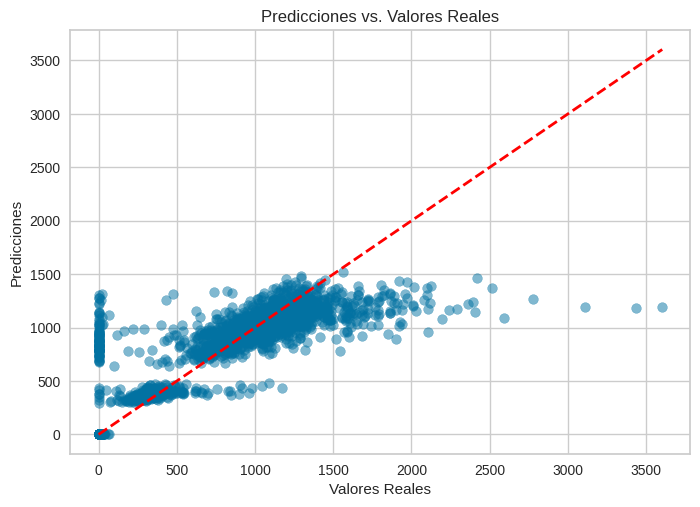

In [97]:
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', linewidth=2)
plt.title('Predicciones vs. Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()

In [98]:
mae = mean_absolute_error(y_true, y_pred)
mse = MSE(y_true, y_pred)
r2 = R2(y_true, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R2: {r2}')

Mean Absolute Error (MAE): 185.12094299276612
Mean Squared Error (MSE): 99089.34014117518
R2: 0.6748219507729569


In [99]:
validacion['fecha_index'] = validacion['fecha']
validacion['fecha_index2'] = validacion['fecha']

In [100]:
def prediccion(fecha_inicial, fecha_final, df):
  inicio = datetime.strptime(fecha_inicial, '%Y/%m/%d')
  fin = datetime.strptime(fecha_final, '%Y/%m/%d')

  mask = (datos1['fecha'] >= inicio) & (df1['fecha'] <= fin)

  registros = datos1.loc[mask]['prediccion'].sum()

  return registros

In [101]:
prediccion_2012_2016=validacion[['fecha','prediccion']]
prediccion_2012_2016

,fecha,prediccion
0,2012-01-01,0.000132
1,2012-01-02,780.113885
2,2012-01-03,933.848857
3,2012-01-04,1054.065200
4,2012-01-05,1097.697071
...,...,...
1822,2016-12-27,1012.749244
1823,2016-12-28,1143.122601
1824,2016-12-29,1190.440905
1825,2016-12-30,1253.061969


In [102]:
prediccion_2012_2016.to_excel('prediccion_2012_2016.xlsx', encoding = 'utf-8', index = False)

##Segundo archivo plano prediccion primer semestre 2018

In [103]:
inicio1 = datetime(2018,1,1)
fin1    = datetime(2018,6,30)

lista_fechas = [inicio1 + timedelta(days=d) for d in range((fin1 - inicio1).days + 1)]


validacion = pd.DataFrame(lista_fechas, columns=['fecha'])
anio=pd.DataFrame({'fecha': pd.to_datetime(validacion['fecha'].values)})
validacion['Year']=anio['fecha'].dt.year
validacion['Mes']=anio['fecha'].dt.month
validacion['Dia']=anio['fecha'].dt.day
validacion['DiaNom'] = anio['fecha'].dt.day_name()
validacion['festivos'] = np.where(validacion.loc[:,'fecha'].isin(festivos['holidays_fecha']),1,0)
validacion['quincena'] = np.where(validacion.loc[:,'fecha'].dt.day.isin([15,30,31]),1,0)

In [104]:
validacion =pd.get_dummies(validacion)
validacion.head(20)

,fecha,Year,Mes,Dia,festivos,quincena,DiaNom_Friday,DiaNom_Monday,DiaNom_Saturday,DiaNom_Sunday,DiaNom_Thursday,DiaNom_Tuesday,DiaNom_Wednesday
0,2018-01-01,2018,1,1,1,0,0,1,0,0,0,0,0
1,2018-01-02,2018,1,2,0,0,0,0,0,0,0,1,0
2,2018-01-03,2018,1,3,0,0,0,0,0,0,0,0,1
3,2018-01-04,2018,1,4,0,0,0,0,0,0,1,0,0
4,2018-01-05,2018,1,5,0,0,1,0,0,0,0,0,0
5,2018-01-06,2018,1,6,0,0,0,0,1,0,0,0,0
6,2018-01-07,2018,1,7,0,0,0,0,0,1,0,0,0
7,2018-01-08,2018,1,8,1,0,0,1,0,0,0,0,0
8,2018-01-09,2018,1,9,0,0,0,0,0,0,0,1,0
9,2018-01-10,2018,1,10,0,0,0,0,0,0,0,0,1


In [105]:
validacion["prediccion"] = model.predict(validacion)

In [106]:
validacion

,fecha,Year,Mes,Dia,festivos,quincena,DiaNom_Friday,DiaNom_Monday,DiaNom_Saturday,DiaNom_Sunday,DiaNom_Thursday,DiaNom_Tuesday,DiaNom_Wednesday,prediccion
0,2018-01-01,2018,1,1,1,0,0,1,0,0,0,0,0,570.059994
1,2018-01-02,2018,1,2,0,0,0,0,0,0,0,1,0,682.400203
2,2018-01-03,2018,1,3,0,0,0,0,0,0,0,0,1,770.247028
3,2018-01-04,2018,1,4,0,0,0,0,0,0,1,0,0,802.130557
4,2018-01-05,2018,1,5,0,0,1,0,0,0,0,0,0,815.106717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,2018-06-26,2018,6,26,0,0,0,0,0,0,0,1,0,853.488403
177,2018-06-27,2018,6,27,0,0,0,0,0,0,0,0,1,963.359774
178,2018-06-28,2018,6,28,0,0,0,0,0,0,1,0,0,1003.236993
179,2018-06-29,2018,6,29,0,0,1,0,0,0,0,0,0,1019.466475


In [107]:
prediccion_01_2018=validacion[['fecha','prediccion']]
prediccion_01_2018

,fecha,prediccion
0,2018-01-01,570.059994
1,2018-01-02,682.400203
2,2018-01-03,770.247028
3,2018-01-04,802.130557
4,2018-01-05,815.106717
...,...,...
176,2018-06-26,853.488403
177,2018-06-27,963.359774
178,2018-06-28,1003.236993
179,2018-06-29,1019.466475


In [108]:
prediccion_01_2018.to_excel('prediccion_01_2018.xlsx', encoding = 'utf-8', index = False)